In [1]:
import os
import numpy as np
import torch
import open_clip
from open_clip import tokenizer

from PIL import Image
import IPython.display
import matplotlib.pyplot as plt
from collections import OrderedDict

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 179,385,345
Context length: 77
Vocab size: 49408


In [7]:
images_dir = "/Users/royzheng/Downloads/tmp/combine/keyframes"
images = []
images_names = []
for filename in [filename for filename in os.listdir(images_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    #print(name)
    # read image and preproess it and store
    image = Image.open(os.path.join(images_dir, filename)).convert("RGB")
    images.append(preprocess(image))
    images_names.append(name)
print(f"total images - {len(images)}")
print(f"size of image - {images[0].shape}")

total images - 291
size of image - torch.Size([3, 256, 256])


In [5]:
# create embeddings of each image and map embedding to filename 
image_input = torch.tensor(np.stack(images))
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)

In [21]:
image_features[0].dtype

torch.float32

In [17]:

# Convert PyTorch tensors to NumPy arrays
embeddings_np = [embedding.detach().numpy() for embedding in image_features]
image_data = {embedding.tobytes(): name for name, embedding in zip(images_names, embeddings_np)}

vector_len = image_features[0].size()[0]

In [41]:
import faiss
# Create an faiss index
index = faiss.IndexFlatL2(vector_len)  # L2 distance for vector_len dimentional vectors

# Add the vectors to the index
index.add(image_features)


In [51]:
# Create text embeddings and use it to query the faiss
#query_tokens = tokenizer.tokenize(["This is " + "helicopeters flying overhead"])
query_tokens = tokenizer.tokenize(["This is " + "street artists playing violin"])
with torch.no_grad():
    query_features = model.encode_text(query_tokens).float()
query_features /= query_features.norm(dim=-1, keepdim=True)
# Search for the 5 nearest neighbors of the query vector
distances, indices = index.search(query_features, 5)

Distance: 1.1696012020111084, index: 266, name: frame-281.png
Distance: 1.1876702308654785, index: 245, name: frame-285.png
Distance: 1.1884894371032715, index: 230, name: frame-287.png
Distance: 1.1933914422988892, index: 283, name: frame-282.png
Distance: 1.198706865310669, index: 229, name: frame-286.png


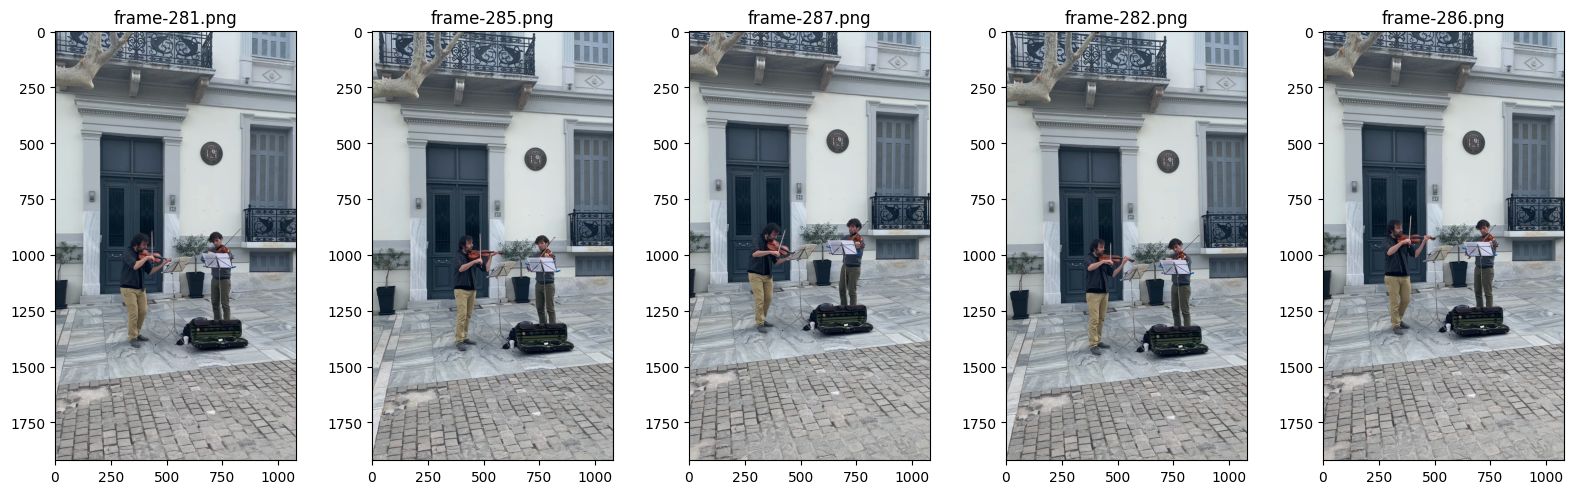

In [52]:
query_images = []
plt.figure(figsize=(16, 5))
for i, vec_index in enumerate(indices[0]):
    name = images_names[vec_index] + ".png"
    image = Image.open(os.path.join(images_dir, name)).convert("RGB")
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"{name}")
    print(f"Distance: {distances[0][i]}, index: {vec_index}, name: {name}")
plt.tight_layout()  